In [283]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [284]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [285]:
filenames[0].split(".")[0]

'cat'

In [286]:
filenames=os.listdir("dogs-vs-cats/train/train")
categories=[]
for filename in filenames:
    category=filename.split(".")[0]
    if category=="dog":
        categories.append(1)
    else:
        categories.append(0)   

In [287]:
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

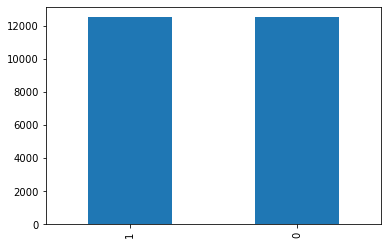

In [288]:
df
df['category'].value_counts().plot.bar()

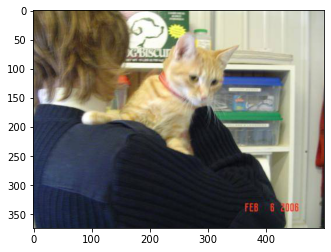

In [289]:
sample=random.choice(filenames)
image=load_img("dogs-vs-cats/train/train/"+sample)
plt.imshow(image)

In [290]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 64)      

In [291]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [292]:
earlystop = EarlyStopping(patience=10)


In [293]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, # new lr = old lr / 2 
                                            min_lr=0.00001)

In [294]:
callbacks = [earlystop, learning_rate_reduction]

In [295]:
df['category']=df['category'].replace({0:'cat', 1:'dog'})
df['category']

0        cat
1        cat
2        cat
3        cat
4        cat
        ... 
24995    dog
24996    dog
24997    dog
24998    dog
24999    dog
Name: category, Length: 25000, dtype: object

In [296]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)

In [297]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

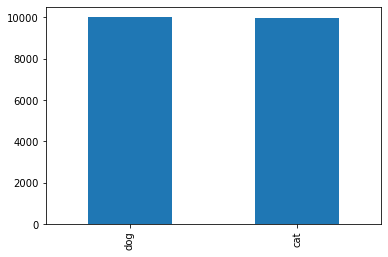

In [298]:
train_df['category'].value_counts().plot.bar()


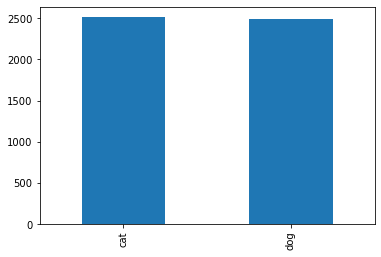

In [299]:
validate_df['category'].value_counts().plot.bar()


In [300]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [301]:
total_train #2만
total_validate #5천

5000

In [302]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [303]:
train_generator=train_datagen.flow_from_dataframe(
train_df,
    "dogs-vs-cats/train/train/",
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [304]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "dogs-vs-cats/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)


Found 5000 validated image filenames belonging to 2 classes.


In [305]:
example_df=train_df.sample(1).reset_index(drop=True)

In [306]:
example_generator=train_datagen.flow_from_dataframe(
example_df,
"dogs-vs-cats/train/train/",
 x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'    
)

Found 1 validated image filenames belonging to 1 classes.


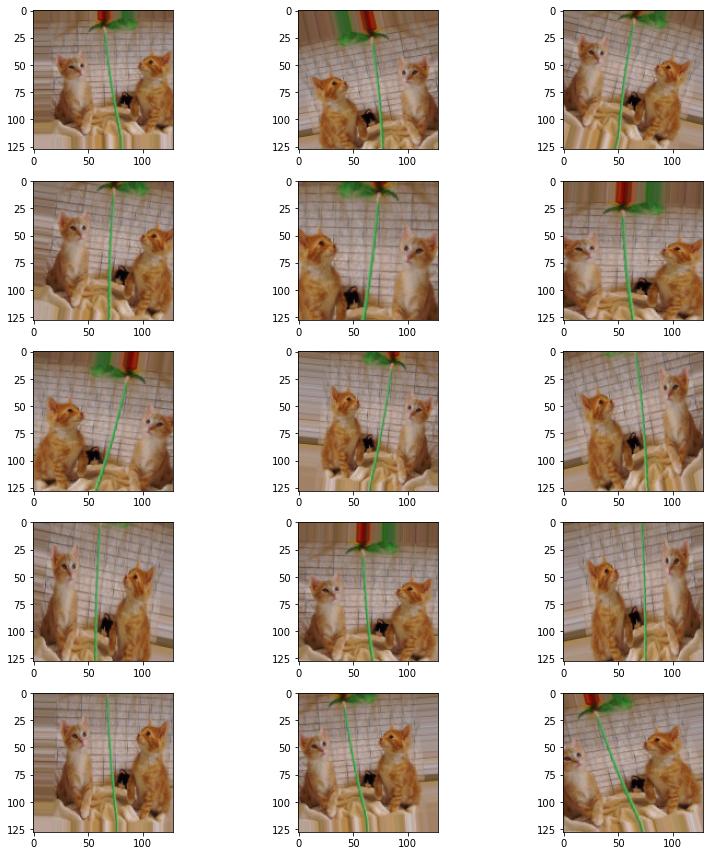

In [307]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [ ]:
history = model.fit_generator(
    train_generator, 
    epochs=3,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/3
 899/1333 [===================>..........] - ETA: 4:46 - loss: 0.8097 - accuracy: 0.6205

In [ ]:
#model.save_weights("model.h5")

In [309]:
model=load_weights("mymodel.h5")

NameError: name 'load_weights' is not defined

In [ ]:
test_filenames = os.listdir("dogs-vs-cats/test1/test1/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "dogs-vs-cats/test1/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [ ]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })


In [ ]:
test_df['category'].value_counts().plot.bar()


In [268]:
train_df

,filename,category
0,dog.8479.jpg,dog
1,dog.876.jpg,dog
2,cat.10915.jpg,cat
3,dog.10127.jpg,dog
4,cat.11377.jpg,cat
...,...,...
19995,dog.6916.jpg,dog
19996,cat.36.jpg,cat
19997,cat.10771.jpg,cat
19998,dog.1713.jpg,dog


In [ ]:
#dropout

In [23]:
#########연습#########

In [24]:
from keras.datasets import boston_housing

(X_train, y_train), (X_test, y_test) = boston_housing.load_data()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

57344/57026 [==============================] - 0s 1us/step
(404, 13) (102, 13) (404,) (102,)


In [29]:
from keras.models import Sequential
model = Sequential()

In [30]:
from keras.layers import Activation, Dense
model.add(Dense(10, input_shape = (13,)))  #입력
model.add(Activation('sigmoid'))
model.add(Dense(10))                        #히든1
model.add(Activation('sigmoid'))
model.add(Dense(10))                        #히든2
model.add(Activation('sigmoid'))
model.add(Dense(1))     #출력

In [31]:
#이렇게 작성해도 동일함
# model.add(Dense(10, input_shape = (13,), activation = 'sigmoid'))
# model.add(Dense(10, activation = 'sigmoid'))
# model.add(Dense(10, activation = 'sigmoid'))
# model.add(Dense(1))

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 10)                140       
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                110       
_________________________________________________________________
activation_4 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                110       
_________________________________________________________________
activation_5 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [33]:
from keras import optimizers
sgd = optimizers.SGD(lr = 0.01)    #w:=w- alpha(lr) * (cost함수를 w에대해 편미분)
model.compile(optimizer = sgd, loss = 'mean_squared_error', metrics = ['mse'])  

In [36]:
model.fit(X_train, y_train, batch_size = 50, epochs = 100, verbose = 1)
#batch_size:한 번에 몇개의 데이터를 학습할건가?
#verebose:학습과정출력여부?

Epoch 1/100
9/9 [==============================] - 0s 2ms/step - loss: 87.2894 - mse: 87.2894
Epoch 2/100
9/9 [==============================] - 0s 1ms/step - loss: 86.6811 - mse: 86.6811
Epoch 3/100
9/9 [==============================] - 0s 1ms/step - loss: 85.5111 - mse: 85.5111
Epoch 4/100
9/9 [==============================] - 0s 1ms/step - loss: 85.4269 - mse: 85.4269
Epoch 5/100
9/9 [==============================] - 0s 2ms/step - loss: 84.8582 - mse: 84.8582
Epoch 6/100
9/9 [==============================] - 0s 1ms/step - loss: 84.7947 - mse: 84.7947
Epoch 7/100
9/9 [==============================] - 0s 1ms/step - loss: 85.2022 - mse: 85.2022
Epoch 8/100
9/9 [==============================] - 0s 1ms/step - loss: 85.1774 - mse: 85.1774
Epoch 9/100
9/9 [==============================] - 0s 2ms/step - loss: 85.1488 - mse: 85.1488
Epoch 10/100
9/9 [==============================] - 0s 2ms/step - loss: 85.0318 - mse: 85.0318
Epoch 11/100
9/9 [==============================] - 0s 2ms/

In [37]:
results = model.evaluate(X_test, y_test)

print(model.metrics_names)     
print(results)                

print('loss: ', results[0])
print('mse: ', results[1])

4/4 [==============================] - 0s 1ms/step - loss: 83.5969 - mse: 83.5969
['loss', 'mse']
[83.59693145751953, 83.59693145751953]
loss:  83.59693145751953
mse:  83.59693145751953


In [41]:
##### 분류#####
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

whole_data = load_breast_cancer()
whole_data.keys()
whole_data

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

In [42]:
X_data = whole_data.data
y_data = whole_data.target

In [44]:
y_data

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.3, random_state = 7) 

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(398, 30) (171, 30) (398,) (171,)


In [51]:
from keras.models import Sequential
model = Sequential()  

In [52]:
from keras.layers import Activation, Dense
model.add(Dense(10, input_shape = (30,), activation = 'sigmoid'))
model.add(Dense(10, activation = 'sigmoid'))
model.add(Dense(10, activation = 'sigmoid'))
model.add(Dense(1, activation = 'sigmoid'))

# model.add(Dense(10, input_shape = (30,)))   
# model.add(Activation('sigmoid'))
# model.add(Dense(10))                        
# model.add(Dense(10))                      
# model.add(Activation('sigmoid'))
# model.add(Dense(1))                          
# model.add(Activation('sigmoid'))     

In [53]:
from keras import optimizers
sgd = optimizers.SGD(lr = 0.01)    # stochastic gradient descent optimizer
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = ['acc'])   

In [54]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_21 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_22 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 11        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.fit(X_train, y_train, batch_size = 50, epochs = 100, verbose = 1)


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6900 - acc: 0.6055
Epoch 2/100
8/8 [==============================] - 0s 1ms/step - loss: 0.6866 - acc: 0.6055
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 0.6844 - acc: 0.6055
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6826 - acc: 0.6055
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6808 - acc: 0.6055
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6793 - acc: 0.6055
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6781 - acc: 0.6055
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6771 - acc: 0.6055
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6762 - acc: 0.6055
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 0.6752 - acc: 0.6055
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6746 

In [56]:
results = model.evaluate(X_test, y_test)

print(model.metrics_names)
print(results)             

6/6 [==============================] - 0s 1ms/step - loss: 0.6363 - acc: 0.6784
['loss', 'acc']
[0.6362770199775696, 0.6783625483512878]


In [57]:
###### 분류(mnist) ########

In [105]:
from keras.datasets import mnist
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = mnist.load_data()

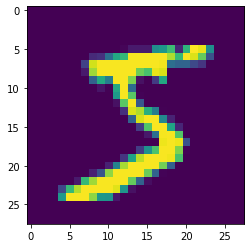

Label:  5


In [106]:
plt.imshow(X_train[0])  
plt.show()
print('Label: ', y_train[0])


In [107]:
#여러층(다층) 퍼셉트론은 1차원 벡터 형태로 데이터를 입력받음
#(28,28)->784 변경 후 입력

In [108]:
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

In [109]:
X_train.shape[0]
X_train=X_train.reshape( (X_train.shape[0],-1) )

In [110]:
X_train.shape

(60000, 784)

In [111]:
X_test=X_test.reshape( (X_test.shape[0],-1) )

In [112]:
X_test.shape

(10000, 784)

In [113]:
X_train, _ , y_train, _ =train_test_split(X_train, y_train, test_size = 0.67, random_state = 7)
#6 만개 중에서 1/3에 해당되는 데이터로만 모델 만들겠다

In [114]:
X_train.shape 

(19800, 784)

In [115]:
X_test.shape

(10000, 784)

In [116]:
y_train[0]

6

In [117]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [118]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(19800, 784) (10000, 784) (19800, 10) (10000, 10)


In [119]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras import optimizers

model = Sequential()
model.add(Dense(50, input_shape = (784, )))
model.add(Activation('sigmoid'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('softmax'))

sgd = optimizers.SGD(lr = 0.001)
model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train, batch_size = 256, 
                    validation_split = 0.3, epochs = 100, verbose = 0)

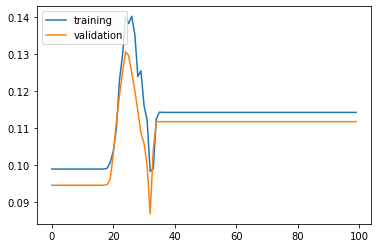

In [120]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [121]:
results = model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

313/313 [==============================] - 0s 1ms/step - loss: 2.3000 - accuracy: 0.1135
Test accuracy:  0.11349999904632568


In [124]:
#가중치초기화
#기본 : 랜덤하게 가중치가 초기화됨(random_uniform)
#르쿤 초기화 -> Xavier 초기화 -> He 초기화(resnet, 2015)

In [127]:
from keras.datasets import mnist
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [128]:
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

# reshaping X data: (n, 28, 28) => (n, 784)
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

X_train, _ , y_train, _ = train_test_split(X_train, y_train, test_size = 0.67, random_state = 7)


y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(19800, 784) (10000, 784) (19800, 10) (10000, 10)


In [129]:
def mlp_model():
    model = Sequential()
    
    model.add(Dense(50, input_shape = (784, ), kernel_initializer='he_normal'))     # use he_normal initializer
    model.add(Activation('sigmoid'))    
    model.add(Dense(50, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('sigmoid'))    
    model.add(Dense(50, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('sigmoid'))    
    model.add(Dense(50, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('sigmoid'))    
    model.add(Dense(10, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('softmax'))
    
    sgd = optimizers.SGD(lr = 0.001)
    model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [130]:
model = mlp_model()
history = model.fit(X_train, y_train, validation_split = 0.3, epochs = 100, verbose = 1)

Epoch 1/100
434/434 [==============================] - 1s 2ms/step - loss: 2.5382 - accuracy: 0.0970 - val_loss: 2.4085 - val_accuracy: 0.1007
Epoch 2/100
434/434 [==============================] - 1s 2ms/step - loss: 2.3596 - accuracy: 0.1084 - val_loss: 2.3307 - val_accuracy: 0.1209
Epoch 3/100
434/434 [==============================] - 1s 2ms/step - loss: 2.3145 - accuracy: 0.1303 - val_loss: 2.3069 - val_accuracy: 0.1296
Epoch 4/100
434/434 [==============================] - 1s 2ms/step - loss: 2.2998 - accuracy: 0.1328 - val_loss: 2.2983 - val_accuracy: 0.1692
Epoch 5/100
434/434 [==============================] - 1s 2ms/step - loss: 2.2942 - accuracy: 0.1846 - val_loss: 2.2945 - val_accuracy: 0.1594
Epoch 6/100
434/434 [==============================] - 1s 2ms/step - loss: 2.2914 - accuracy: 0.1478 - val_loss: 2.2922 - val_accuracy: 0.1460
Epoch 7/100
434/434 [==============================] - 1s 2ms/step - loss: 2.2894 - accuracy: 0.1469 - val_loss: 2.2904 - val_accuracy: 0.1330

Epoch 58/100
434/434 [==============================] - 1s 2ms/step - loss: 2.1622 - accuracy: 0.3386 - val_loss: 2.1625 - val_accuracy: 0.3291
Epoch 59/100
434/434 [==============================] - 1s 2ms/step - loss: 2.1573 - accuracy: 0.3406 - val_loss: 2.1575 - val_accuracy: 0.3315
Epoch 60/100
434/434 [==============================] - 1s 2ms/step - loss: 2.1521 - accuracy: 0.3390 - val_loss: 2.1523 - val_accuracy: 0.3332
Epoch 61/100
434/434 [==============================] - 1s 2ms/step - loss: 2.1467 - accuracy: 0.3396 - val_loss: 2.1470 - val_accuracy: 0.3418
Epoch 62/100
434/434 [==============================] - 1s 2ms/step - loss: 2.1412 - accuracy: 0.3457 - val_loss: 2.1416 - val_accuracy: 0.3438
Epoch 63/100
434/434 [==============================] - 1s 2ms/step - loss: 2.1355 - accuracy: 0.3512 - val_loss: 2.1359 - val_accuracy: 0.3436
Epoch 64/100
434/434 [==============================] - 1s 2ms/step - loss: 2.1295 - accuracy: 0.3532 - val_loss: 2.1299 - val_accuracy:

In [131]:
results = model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

313/313 [==============================] - 0s 1ms/step - loss: 1.7844 - accuracy: 0.4149
Test accuracy:  0.414900004863739


In [134]:
def mlp_model2():
    model = Sequential()
    
    model.add(Dense(50, input_shape = (784, ), kernel_initializer='he_normal'))     # use he_normal initializer
    model.add(Activation('relu'))    
    model.add(Dense(50, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('relu'))    
    model.add(Dense(50, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('relu'))    
    model.add(Dense(50, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('relu'))    
    model.add(Dense(10, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('softmax'))
    
    sgd = optimizers.SGD(lr = 0.001)
    model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [135]:
model = mlp_model2()
history = model.fit(X_train, y_train, validation_split = 0.3, epochs = 100, verbose = 1)

Epoch 1/100
434/434 [==============================] - 1s 2ms/step - loss: 3.6430 - accuracy: 0.5076 - val_loss: 1.3606 - val_accuracy: 0.5714
Epoch 2/100
434/434 [==============================] - 1s 2ms/step - loss: 0.9505 - accuracy: 0.7004 - val_loss: 1.1685 - val_accuracy: 0.6515
Epoch 3/100
434/434 [==============================] - 1s 2ms/step - loss: 0.7178 - accuracy: 0.7825 - val_loss: 0.6675 - val_accuracy: 0.8056
Epoch 4/100
434/434 [==============================] - 1s 2ms/step - loss: 0.5936 - accuracy: 0.8237 - val_loss: 0.8018 - val_accuracy: 0.7722
Epoch 5/100
434/434 [==============================] - 1s 2ms/step - loss: 0.5132 - accuracy: 0.8457 - val_loss: 0.6143 - val_accuracy: 0.8247
Epoch 6/100
434/434 [==============================] - 1s 2ms/step - loss: 0.4665 - accuracy: 0.8632 - val_loss: 0.5481 - val_accuracy: 0.8404
Epoch 7/100
434/434 [==============================] - 1s 2ms/step - loss: 0.4267 - accuracy: 0.8712 - val_loss: 0.4903 - val_accuracy: 0.8579

Epoch 58/100
434/434 [==============================] - 1s 2ms/step - loss: 0.1067 - accuracy: 0.9679 - val_loss: 0.4192 - val_accuracy: 0.9047
Epoch 59/100
434/434 [==============================] - 1s 2ms/step - loss: 0.1050 - accuracy: 0.9677 - val_loss: 0.4193 - val_accuracy: 0.9062
Epoch 60/100
434/434 [==============================] - 1s 2ms/step - loss: 0.1043 - accuracy: 0.9694 - val_loss: 0.4249 - val_accuracy: 0.9071
Epoch 61/100
434/434 [==============================] - 1s 2ms/step - loss: 0.1019 - accuracy: 0.9701 - val_loss: 0.4506 - val_accuracy: 0.8992
Epoch 62/100
434/434 [==============================] - 1s 2ms/step - loss: 0.0994 - accuracy: 0.9706 - val_loss: 0.4270 - val_accuracy: 0.9064
Epoch 63/100
434/434 [==============================] - 1s 2ms/step - loss: 0.0996 - accuracy: 0.9704 - val_loss: 0.4255 - val_accuracy: 0.9066
Epoch 64/100
434/434 [==============================] - 1s 2ms/step - loss: 0.0987 - accuracy: 0.9701 - val_loss: 0.4355 - val_accuracy:

In [136]:
results = model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

313/313 [==============================] - 0s 1ms/step - loss: 0.5586 - accuracy: 0.9038
Test accuracy:  0.9038000106811523


In [137]:
#adaptive learning methods

def mlp_model3():
    model = Sequential()
    
    model.add(Dense(50, input_shape = (784, ), kernel_initializer='he_normal'))     # use he_normal initializer
    model.add(Activation('relu'))    
    model.add(Dense(50, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('relu'))    
    model.add(Dense(50, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('relu'))    
    model.add(Dense(50, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('relu'))    
    model.add(Dense(10, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model


In [138]:
model = mlp_model3()
history = model.fit(X_train, y_train, validation_split = 0.3, epochs = 100, verbose = 1)

Epoch 1/100
434/434 [==============================] - 1s 3ms/step - loss: 4.5778 - accuracy: 0.5031 - val_loss: 1.1445 - val_accuracy: 0.6296
Epoch 2/100
434/434 [==============================] - 1s 2ms/step - loss: 0.9474 - accuracy: 0.6841 - val_loss: 0.9020 - val_accuracy: 0.7251
Epoch 3/100
434/434 [==============================] - 1s 3ms/step - loss: 0.7407 - accuracy: 0.7565 - val_loss: 0.7099 - val_accuracy: 0.7803
Epoch 4/100
434/434 [==============================] - 1s 2ms/step - loss: 0.6289 - accuracy: 0.8073 - val_loss: 0.7011 - val_accuracy: 0.7944
Epoch 5/100
434/434 [==============================] - 1s 2ms/step - loss: 0.5440 - accuracy: 0.8360 - val_loss: 0.5362 - val_accuracy: 0.8549
Epoch 6/100
434/434 [==============================] - 1s 2ms/step - loss: 0.4794 - accuracy: 0.8640 - val_loss: 0.5519 - val_accuracy: 0.8601
Epoch 7/100
434/434 [==============================] - 1s 3ms/step - loss: 0.4227 - accuracy: 0.8846 - val_loss: 0.4759 - val_accuracy: 0.8800

Epoch 58/100
434/434 [==============================] - 1s 2ms/step - loss: 0.0734 - accuracy: 0.9803 - val_loss: 0.4202 - val_accuracy: 0.9298
Epoch 59/100
434/434 [==============================] - 1s 2ms/step - loss: 0.0821 - accuracy: 0.9769 - val_loss: 0.3748 - val_accuracy: 0.9311
Epoch 60/100
434/434 [==============================] - 1s 2ms/step - loss: 0.0722 - accuracy: 0.9792 - val_loss: 0.3786 - val_accuracy: 0.9305
Epoch 61/100
434/434 [==============================] - 1s 3ms/step - loss: 0.0797 - accuracy: 0.9763 - val_loss: 0.4084 - val_accuracy: 0.9315
Epoch 62/100
434/434 [==============================] - 1s 2ms/step - loss: 0.0764 - accuracy: 0.9788 - val_loss: 0.4366 - val_accuracy: 0.9288
Epoch 63/100
434/434 [==============================] - 1s 2ms/step - loss: 0.0792 - accuracy: 0.9779 - val_loss: 0.4175 - val_accuracy: 0.9301
Epoch 64/100
434/434 [==============================] - 1s 2ms/step - loss: 0.0776 - accuracy: 0.9784 - val_loss: 0.3938 - val_accuracy:

In [ ]:
####배치 정규화####
#입력값을 평균을 0, 분산을 1로 정규화한 네트워크 -> 학습이 잘 이루어짐


In [139]:
from keras.layers import BatchNormalization

In [140]:
def mlp_model4():
    model = Sequential()
    
    model.add(Dense(50, input_shape = (784, ), kernel_initializer='he_normal'))     # use he_normal initializer
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dense(50, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dense(50, kernel_initializer='he_normal')) 
    # use he_normal initializer
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dense(50, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dense(10, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model


In [141]:
model = mlp_model4()
history = model.fit(X_train, y_train, validation_split = 0.3, epochs = 100, verbose = 1)

Epoch 1/100
434/434 [==============================] - 2s 4ms/step - loss: 0.7090 - accuracy: 0.7949 - val_loss: 0.2783 - val_accuracy: 0.9231
Epoch 2/100
434/434 [==============================] - 1s 3ms/step - loss: 0.2996 - accuracy: 0.9146 - val_loss: 0.2042 - val_accuracy: 0.9374
Epoch 3/100
434/434 [==============================] - 1s 3ms/step - loss: 0.2350 - accuracy: 0.9289 - val_loss: 0.1900 - val_accuracy: 0.9431
Epoch 4/100
434/434 [==============================] - 1s 3ms/step - loss: 0.1797 - accuracy: 0.9451 - val_loss: 0.1770 - val_accuracy: 0.9483
Epoch 5/100
434/434 [==============================] - 1s 3ms/step - loss: 0.1670 - accuracy: 0.9505 - val_loss: 0.1539 - val_accuracy: 0.9545
Epoch 6/100
434/434 [==============================] - 1s 3ms/step - loss: 0.1420 - accuracy: 0.9556 - val_loss: 0.1552 - val_accuracy: 0.9529
Epoch 7/100
434/434 [==============================] - 1s 3ms/step - loss: 0.1294 - accuracy: 0.9584 - val_loss: 0.1509 - val_accuracy: 0.9515

Epoch 58/100
434/434 [==============================] - 1s 3ms/step - loss: 0.0293 - accuracy: 0.9895 - val_loss: 0.1486 - val_accuracy: 0.9660
Epoch 59/100
434/434 [==============================] - 1s 3ms/step - loss: 0.0241 - accuracy: 0.9921 - val_loss: 0.1486 - val_accuracy: 0.9643
Epoch 60/100
434/434 [==============================] - 1s 3ms/step - loss: 0.0171 - accuracy: 0.9938 - val_loss: 0.1590 - val_accuracy: 0.9638
Epoch 61/100
434/434 [==============================] - 1s 3ms/step - loss: 0.0183 - accuracy: 0.9948 - val_loss: 0.1578 - val_accuracy: 0.9633
Epoch 62/100
434/434 [==============================] - 1s 3ms/step - loss: 0.0282 - accuracy: 0.9910 - val_loss: 0.1652 - val_accuracy: 0.9620
Epoch 63/100
434/434 [==============================] - 1s 3ms/step - loss: 0.0270 - accuracy: 0.9904 - val_loss: 0.1642 - val_accuracy: 0.9640
Epoch 64/100
434/434 [==============================] - 1s 3ms/step - loss: 0.0198 - accuracy: 0.9926 - val_loss: 0.1506 - val_accuracy:

In [142]:
########dropout 추가, 오버피팅 감소#######

In [143]:
from keras.layers import Dropout

In [144]:
def mlp_model5():
    model = Sequential()
    
    model.add(Dense(50, input_shape = (784, ), kernel_initializer='he_normal'))     # use he_normal initializer
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal')) 
    # use he_normal initializer
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.2))
    model.add(Dense(10, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model


In [145]:
model = mlp_model5()
history = model.fit(X_train, y_train, validation_split = 0.3, epochs = 100, verbose = 1)

Epoch 1/100
434/434 [==============================] - 2s 4ms/step - loss: 1.3590 - accuracy: 0.5615 - val_loss: 0.4415 - val_accuracy: 0.8805
Epoch 2/100
434/434 [==============================] - 1s 3ms/step - loss: 0.7075 - accuracy: 0.7885 - val_loss: 0.3078 - val_accuracy: 0.9089
Epoch 3/100
434/434 [==============================] - 2s 4ms/step - loss: 0.5666 - accuracy: 0.8337 - val_loss: 0.2768 - val_accuracy: 0.9168
Epoch 4/100
434/434 [==============================] - 1s 3ms/step - loss: 0.4985 - accuracy: 0.8532 - val_loss: 0.2356 - val_accuracy: 0.9283
Epoch 5/100
434/434 [==============================] - 1s 3ms/step - loss: 0.4611 - accuracy: 0.8677 - val_loss: 0.2231 - val_accuracy: 0.9322
Epoch 6/100
434/434 [==============================] - 1s 3ms/step - loss: 0.4237 - accuracy: 0.8770 - val_loss: 0.2050 - val_accuracy: 0.9391
Epoch 7/100
434/434 [==============================] - 1s 3ms/step - loss: 0.4033 - accuracy: 0.8810 - val_loss: 0.2072 - val_accuracy: 0.9365

Epoch 58/100
434/434 [==============================] - 1s 3ms/step - loss: 0.1603 - accuracy: 0.9531 - val_loss: 0.1445 - val_accuracy: 0.9591
Epoch 59/100
434/434 [==============================] - 1s 3ms/step - loss: 0.1550 - accuracy: 0.9519 - val_loss: 0.1439 - val_accuracy: 0.9599
Epoch 60/100
434/434 [==============================] - 1s 3ms/step - loss: 0.1582 - accuracy: 0.9516 - val_loss: 0.1406 - val_accuracy: 0.9588
Epoch 61/100
434/434 [==============================] - 1s 3ms/step - loss: 0.1461 - accuracy: 0.9567 - val_loss: 0.1474 - val_accuracy: 0.9588
Epoch 62/100
434/434 [==============================] - 1s 3ms/step - loss: 0.1464 - accuracy: 0.9545 - val_loss: 0.1470 - val_accuracy: 0.9611
Epoch 63/100
434/434 [==============================] - 1s 3ms/step - loss: 0.1468 - accuracy: 0.9543 - val_loss: 0.1537 - val_accuracy: 0.9577
Epoch 64/100
434/434 [==============================] - 1s 3ms/step - loss: 0.1615 - accuracy: 0.9516 - val_loss: 0.1351 - val_accuracy:

In [146]:
###앙상블 기법###

In [147]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

In [148]:
def mlp_model6():
    model = Sequential()
    
    model.add(Dense(50, input_shape = (784, ), kernel_initializer='he_normal'))     # use he_normal initializer
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal')) 
    # use he_normal initializer
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.2))
    model.add(Dense(10, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model


In [154]:
model1=KerasClassifier(build_fn=mlp_model, epochs=100, verbose=1)
model2=KerasClassifier(build_fn=mlp_model, epochs=100, verbose=1)
model3=KerasClassifier(build_fn=mlp_model, epochs=100, verbose=1)

In [155]:
ens_clf=VotingClassifier(estimators=[('model1',model1),('model2',model2),('model3',model3)], voting='soft')

In [156]:
ens_clf.fit(X_train, y_train)

NotImplementedError: Multilabel and multi-output classification is not supported.

In [157]:
def mlp_model():
    model = Sequential()

    model.add(Dense(50, input_shape = (784, ), kernel_initializer='he_normal'))  
    model.add(Activation('relu'))      
    model.add(Dropout(0.2))           
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, kernel_initializer='he_normal'))
    model.add(Activation('softmax'))

    adam = optimizers.Adam(lr = 0.001)    # Adam optimizer 사용
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return model


model1 = KerasClassifier(build_fn = mlp_model, epochs = 100)
model2 = KerasClassifier(build_fn = mlp_model, epochs = 100)
model3 = KerasClassifier(build_fn = mlp_model, epochs = 100)
model4 = KerasClassifier(build_fn = mlp_model, epochs = 100)
model5 = KerasClassifier(build_fn = mlp_model, epochs = 100)

In [158]:
ensemble_clf = VotingClassifier(estimators = [('model1', model1), ('model2', model2), ('model3', model3), ('model4', model4), ('model5', model5)], voting = 'soft')
ensemble_clf.fit(X_train, y_train)

NotImplementedError: Multilabel and multi-output classification is not supported.

In [160]:
from keras.models import Sequential
from keras.layers import *

In [161]:
model = Sequential()
model.add(Conv2D(input_shape = (10, 10, 3), filters = 10, kernel_size = (3,3), strides = (1,1), padding = 'valid'))
print(model.output_shape)

(None, 8, 8, 10)


In [211]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

In [212]:
data = datasets.load_digits()

In [213]:
#data.images.shape
#1797개 숫자 이미지, 각 숫자 이미지의  shape은 8,8

data.images[3] #숫자 이미지
data.target[3] #정답

3

In [214]:
X_data=data.images

In [215]:
y_data=data.target

In [216]:
X_data.shape

(1797, 8, 8)

In [217]:
y_data.shape

(1797,)

In [218]:
X_data=X_data.reshape( (X_data.shape[0], X_data.shape[1], X_data.shape[2], 1) )

In [219]:
y_data = to_categorical(y_data)

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.3, random_state = 777)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1257, 8, 8, 1)
(540, 8, 8, 1)
(1257, 10)
(540, 10)


In [221]:
model = Sequential()


In [222]:
model.add(Conv2D(input_shape = (X_data.shape[1], X_data.shape[2], X_data.shape[3]), filters = 10, kernel_size = (3,3), strides = (1,1), padding = 'valid'))

In [223]:
model.add(Activation('relu'))

In [224]:
model.add(MaxPooling2D(pool_size = (2,2)))

In [225]:
model.add(Flatten())
model.add(Dense(50, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

In [226]:
adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', 
              optimizer = adam, metrics = ['accuracy'])

In [227]:
history = model.fit(X_train, y_train, batch_size = 50, validation_split = 0.2, epochs = 100, verbose = 0)


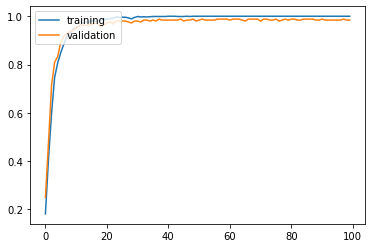

In [229]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [230]:
results = model.evaluate(X_test, y_test)


17/17 [==============================] - 0s 1ms/step - loss: 0.0684 - accuracy: 0.9722


In [231]:
print('Test accuracy: ', results[1])


Test accuracy:  0.9722222089767456


In [232]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.utils.np_utils import to_categorical

(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshaping X data: (n, 28, 28) => (n, 28, 28, 1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
# converting y data into categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000, 10) (10000, 10)


In [233]:
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D

def basic_cnn():
    model = Sequential()

    model.add(Conv2D(input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))

    # prior layer should be flattend to be connected to dense layers
    model.add(Flatten())
    # dense layer with 50 neurons
    model.add(Dense(50, activation = 'relu'))
    # final layer with 10 neurons to classify the instances
    model.add(Dense(10, activation = 'softmax'))

    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

model = basic_cnn()
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 50)        500       
_________________________________________________________________
activation_60 (Activation)   (None, 28, 28, 50)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 50)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9800)              0         
_________________________________________________________________
dense_76 (Dense)             (None, 50)                490050    
_________________________________________________________________
dense_77 (Dense)             (None, 10)                510       
Total params: 491,060
Trainable params: 491,060
Non-trainable params: 0
_______________________________________________

In [234]:
history = model.fit(X_train, y_train, batch_size = 50, validation_split = 0.2, epochs = 100, verbose = 0)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

KeyboardInterrupt: 

In [ ]:
results = model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

In [187]:
from keras.datasets import cifar10

In [188]:
(xtrain,ytrain), _=cifar10.load_data()

170500096/170498071 [==============================] - 15s 0us/step


In [190]:
xtrain.shape #(50000, 32, 32, 3)


(50000, 32, 32, 3)

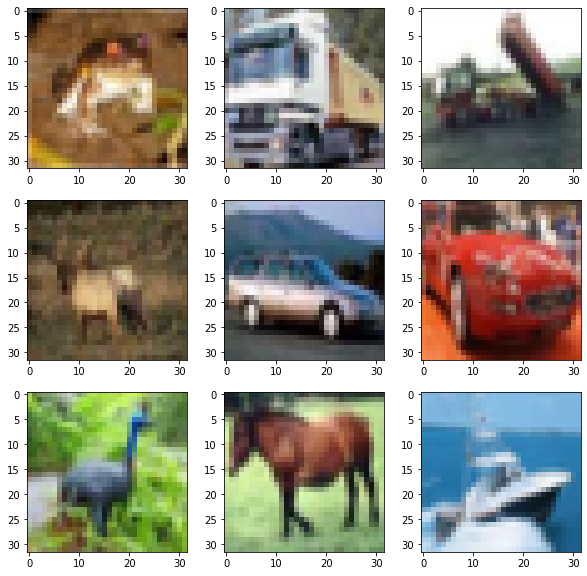

In [192]:
fig = plt.figure(figsize = (10, 10))
for i in range(9):
    fig.add_subplot(3, 3, i+1)
    plt.imshow(xtrain[i])
plt.show()

In [193]:
model = Sequential()

In [194]:
model.add(Conv2D(input_shape = (10, 10, 3), filters = 10, kernel_size = (3,3), strides = (1,1), padding = 'valid'))

In [195]:
print(model.output_shape)



(None, 8, 8, 10)


In [204]:
model = Sequential()

In [205]:
model.add(Conv2D(input_shape = (10, 10, 3), filters = 20, kernel_size = (3,3), strides = (1,1), padding = 'same'))

In [206]:
print(model.output_shape)


(None, 10, 10, 20)


In [207]:
model.add(MaxPooling2D(pool_size = (2,2), padding = 'valid'))


In [208]:
print(model.output_shape)


(None, 5, 5, 20)


In [209]:
model.add(Flatten())


In [210]:
print(model.output_shape)


(None, 500)
